In [1]:
import pandas as pd
import numpy as np
import torch
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from kan import KAN
from kan.utils import ex_round
from kan.custom_utils import remove_outliers_iqr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

dir_current = os.getcwd()
dir_parent = os.path.dirname(dir_current)
filepath = os.path.join(dir_parent, "TaeWoong", "25.01.14_CO2RR_GSA.xlsx")

xls = pd.ExcelFile(filepath)
df_in  = pd.read_excel(xls, sheet_name='Input')
df_out = pd.read_excel(xls, sheet_name='Output')

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)

removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")

This script is running on cpu.
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
--- 이상치 제거 완료 ---



In [2]:
name_X = [
    "Current density (mA/cm2)",
    "Faradaic efficiency (%)",
    "CO coversion",
    "Voltage (V)",
    "Electricity cost ($/kWh)",
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)",
    "Crossover rate"
]
name_y = "Required energy_total (MJ/kgCO)" # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
X = df_in_final[name_X].values


y = df_out_final[name_y].values.reshape(-1, 1)   # df_out_final[] 는 pandas datatframe이기에 이것을 skitlearn 이나 Keras 형태로 바꾸기 -- 그래야
                                                     # .values 를 통해 Numpy 배열로 변환 (값만 뽑기 때문) # 그 후에 reshape(-1.1) 을 통해
                                                     # .reshape()을 이용해 열 1


In [3]:
from sklearn.preprocessing import MinMaxScaler

# 1단계: 먼저 train+val과 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2단계: train+val을 train과 val로 분할 (64:16, 전체 대비)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

# 최종 비율 확인
# (X[:,0])~(X[:,7]) 에 각각의 입력변수들의 값들이 각각 저장됨

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))

X_train_norm = scaler_X.fit_transform(X_train) # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train) # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

# 3. 학습된 스케일러로 검증 및 테스트 데이터 변환 (transform)
# X_train의 기준으로 나머지 데이터들을 변환합니다.
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)   # y_val 과 y_test 도 y_train 의 정규분포를 따라 변환된다
y_test_norm = scaler_y.transform(y_test)

# 딥러닝을 진행하기 전 모든 데이터셋을 tensor로 변환  # 원래는 numpy 배열이었음 --- 아까 scikitlearn의 train test split 이나 .fit transform 스케일러를 사용하였기에
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val_norm, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32, device=device)

print(f"모든 텐서가 {device}에 배치됨")

# 나중에 정의하기 편하게 dataset을 정의하기 -- 참고로 dataset들은 tensor 이다

dataset = {'train_input': X_train_tensor,'train_label': y_train_tensor,
            'val_input': X_val_tensor, 'val_label': y_val_tensor,
            'test_input': X_test_tensor,'test_label': y_test_tensor }    # dataset dictionary에 key값과 value 값을 설정한다

# 데이터셋 검토차 크기 확인
for key, value in dataset.items():                     #.items()를 쓰면 key와 value 값을 묶어서 출력 // .items()가 없으면 오직 key만 출력
    print(f"{key}: {value.shape}")

전체 데이터셋 크기: 2378
훈련셋 크기: 1521 (64.0%)
검증셋 크기: 381 (16.0%)
테스트셋 크기: 476 (20.0%)
모든 텐서가 cpu에 배치됨
train_input: torch.Size([1521, 8])
train_label: torch.Size([1521, 1])
val_input: torch.Size([381, 8])
val_label: torch.Size([381, 1])
test_input: torch.Size([476, 8])
test_label: torch.Size([476, 1])


checkpoint directory created: ./model
saving model version 0.0
학습가능 파라미터 수: 1,296
act_fun.0.coef                           torch.Size([8, 12, 6])   576
act_fun.0.scale_base                     torch.Size([8, 12])    96
act_fun.0.scale_sp                       torch.Size([8, 12])    96
act_fun.1.coef                           torch.Size([12, 1, 6])    72
act_fun.1.scale_base                     torch.Size([12, 1])    12
act_fun.1.scale_sp                       torch.Size([12, 1])    12
symbolic_fun.0.affine                    torch.Size([12, 8, 4])   384
symbolic_fun.1.affine                    torch.Size([1, 12, 4])    48


| train_loss: 2.29e-02 | test_loss: 2.54e-02 | reg: 2.80e+00 | : 100%|█| 50/50 [00:22<00:00,  2.24it


saving model version 0.1
saving model version 0.2


| train_loss: 1.42e-02 | test_loss: 1.46e-02 | reg: 4.26e+00 | : 100%|█| 50/50 [00:05<00:00,  8.53it


saving model version 0.3
saving model version 0.4


| train_loss: 1.20e-02 | test_loss: 1.53e-02 | reg: 4.28e+00 | : 100%|█| 50/50 [00:19<00:00,  2.60it


saving model version 0.5
fixing (0,0,0) with 0
fixing (0,1,0) with x, r2=0.838291347026825, c=1
fixing (0,2,0) with exp, r2=0.9865507483482361, c=2
fixing (0,3,0) with x, r2=0.9892909526824951, c=1
fixing (0,4,0) with 0
fixing (0,5,0) with 0
fixing (0,6,0) with x, r2=0.9088294506072998, c=1
fixing (0,7,0) with 0
fixing (1,0,0) with x, r2=0.9730618596076965, c=1
saving model version 0.6


| train_loss: 2.25e-02 | test_loss: 2.26e-02 | reg: 0.00e+00 | : 100%|█| 50/50 [00:04<00:00, 10.08it


saving model version 0.7


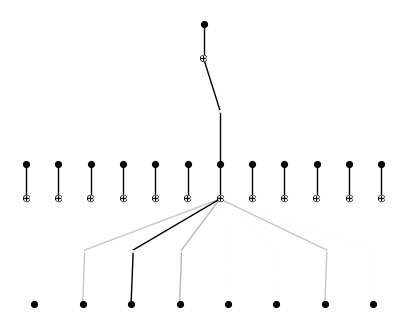

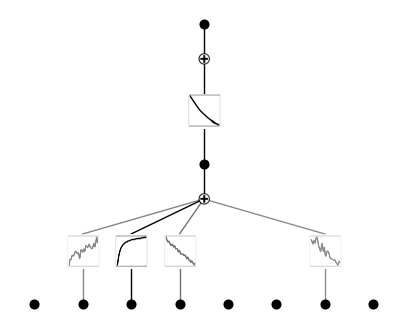

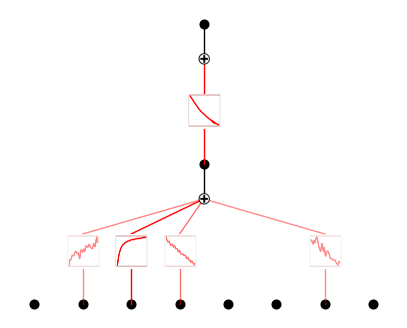

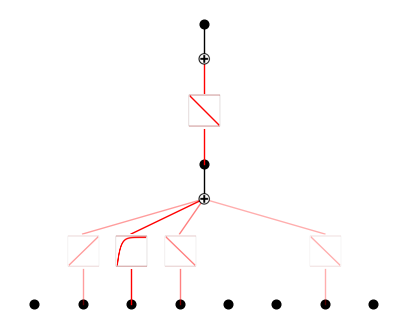

In [4]:
model = KAN(width=[8, 12, 1], grid=3, k=3, seed=42, device=device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"학습가능 파라미터 수: {num_params:,}")

for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name:40s} {p.shape} {p.numel():5d}")

# KAN 학습
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001)
model.plot()

model = model.prune(node_th=1e-2, edge_th=3e-2)  # 더 자르고 싶으면 값을 높이고, 덜 자르고 변수를 많이 있게 하고 싶으면 값을 낮추기

#학습
model.fit(dataset, opt="LBFGS", steps=50)  # update_grid 가 False일때랑 True일때의 차이는?

model = model.refine(30)
model.fit(dataset, opt="LBFGS", steps=50)
model.plot()

lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin']  #'x^(-1)', 'x^(-2)', 'x^(-3)', 'x^(-4)'
model.auto_symbolic(lib=lib)
model.plot()
# symbolic 함수로 대체 후 학습
model.fit(dataset, opt="LBFGS", steps=50)
model.plot()

torch.Size([8, 1, 33])
torch.Size([1, 1, 33])


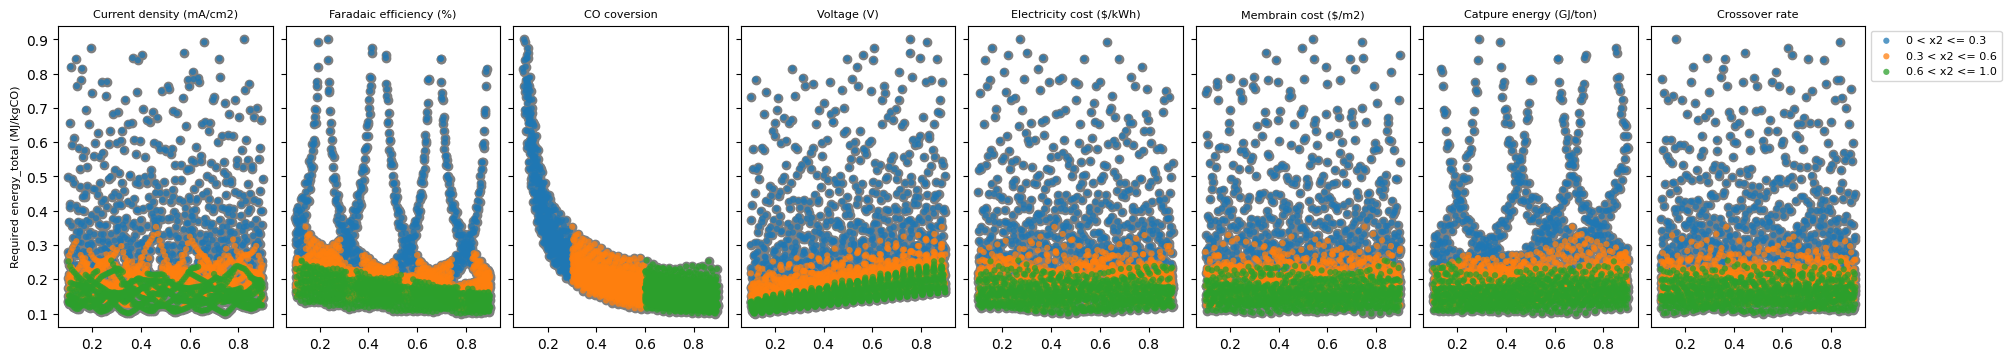

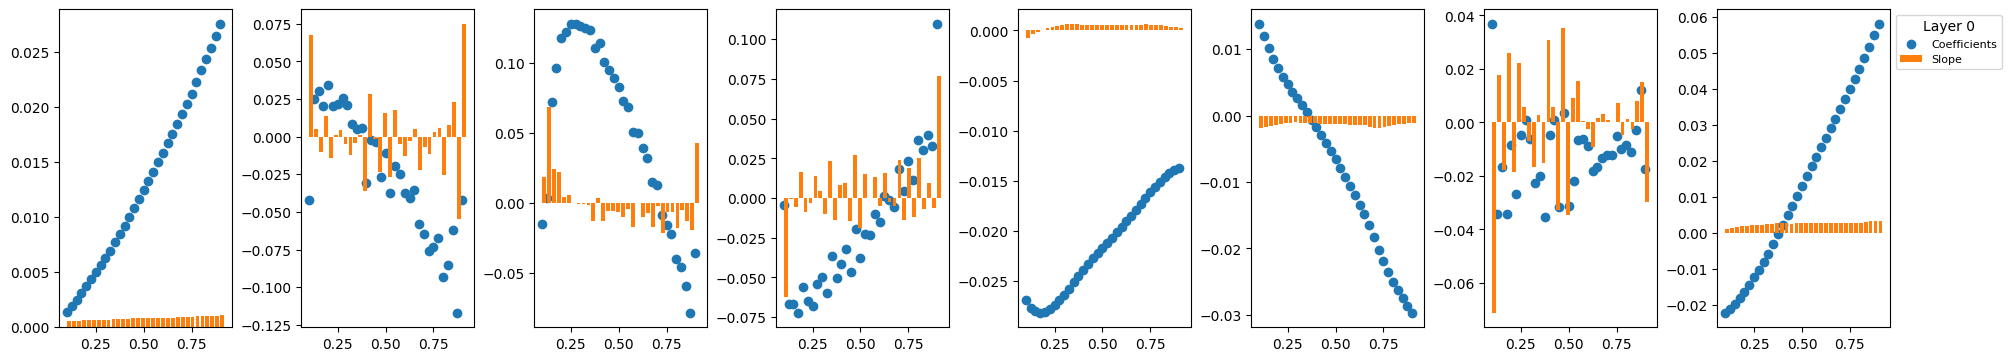

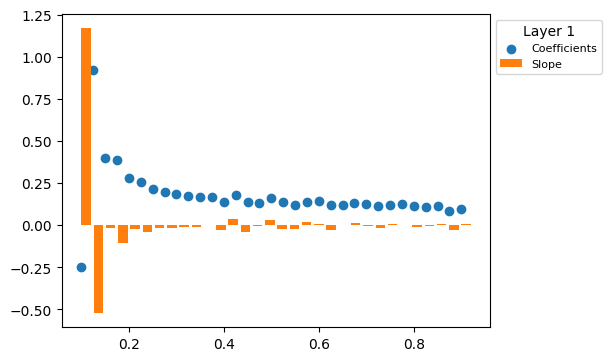

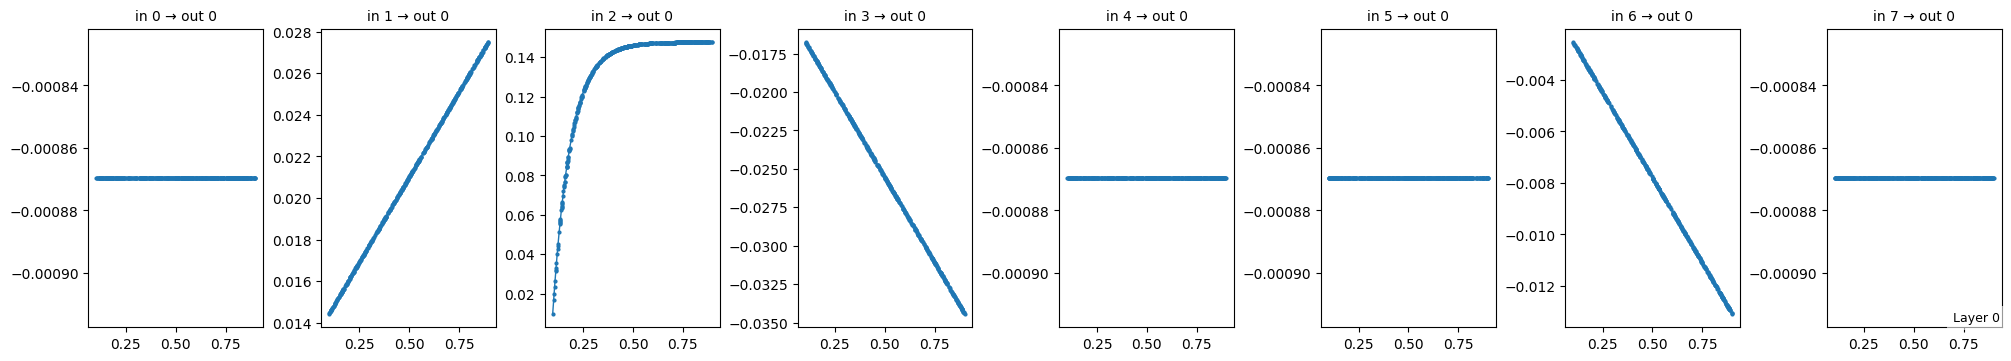

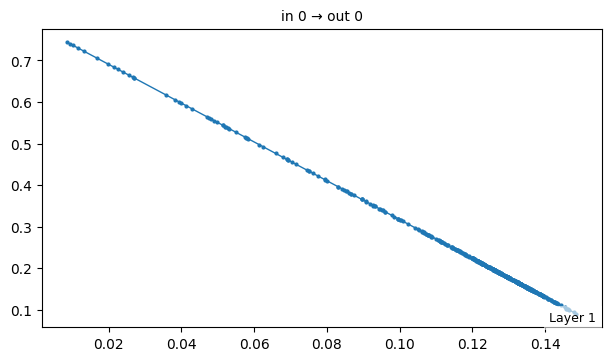

[<Figure size 2000x350 with 8 Axes>, <Figure size 600x350 with 1 Axes>]

In [5]:
import matplotlib.pyplot as plt
from kan.custom_utils import plot_data_per_interval, plot_activation_functions

print(model.act_fun[0].coef.shape)
print(model.act_fun[1].coef.shape)  # After pruning, the second layer maintains a single node.

X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)
# X_norm_selected = X_norm[:, [1, 2, 3, 6]]

fig_x2, axs_x2 = plot_data_per_interval(X_norm, y_norm, name_X, name_y, 2, [0, 0.3, 0.6])
# fig_x2, axs_x2 = plot_data_per_interval(X_norm, y_norm, name_X, 0, [0, 0.2, 0.4, 0.8])

for layer, act_fun in enumerate(model.act_fun):
    ni, no = act_fun.coef.shape[:2]
    coef = act_fun.coef.tolist()
    # Dynamically size figure and use constrained layout to prevent overlaps
    fig, axs = plt.subplots(nrows=no, ncols=ni, figsize=(max(2.5*ni, 6), max(2.5*no, 3.5)), squeeze=False, constrained_layout=True)
    for idx_in, coef_in in enumerate(coef):
        for idx_out, coef_node in enumerate(coef_in):
            ax = axs[idx_out, idx_in]
            ax.scatter(np.linspace(0.1, 0.9, (len(coef_node))), coef_node, label='Coefficients')
            slope = [x - y for x, y in zip(coef_node[1:], coef_node[:-1])]
            ax.bar(np.linspace(0.1, 0.9, len(slope)), slope, width=0.02, align='edge', label='Slope')
    axs[-1, -1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8, title=f'Layer {layer}')

plot_activation_functions(model)

파랑색: B-spline 계수, 주황색: 계수의 변화량
* Energy: Layer 0, Input 2에서 기울기 방향 변함.
* MSP: Layer 0, Input 0 & 2에서 기울기 방향 변함.

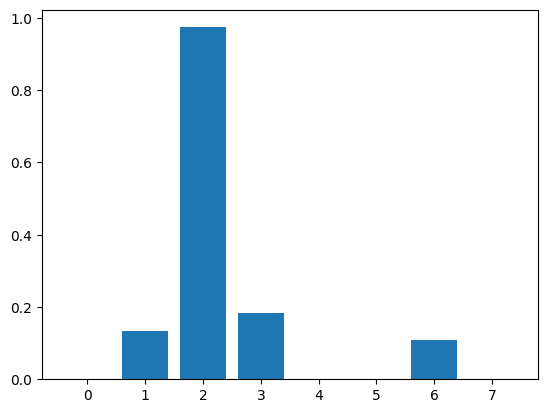

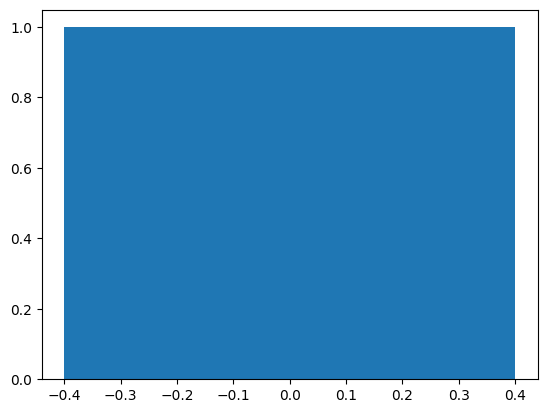

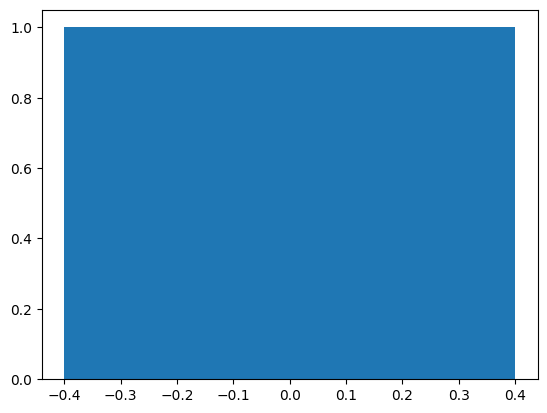

In [6]:
for scores in model.node_scores:
    # print(scores)
    fig, ax = plt.subplots()
    ax.bar(list(range(scores.shape[0])), scores.tolist())